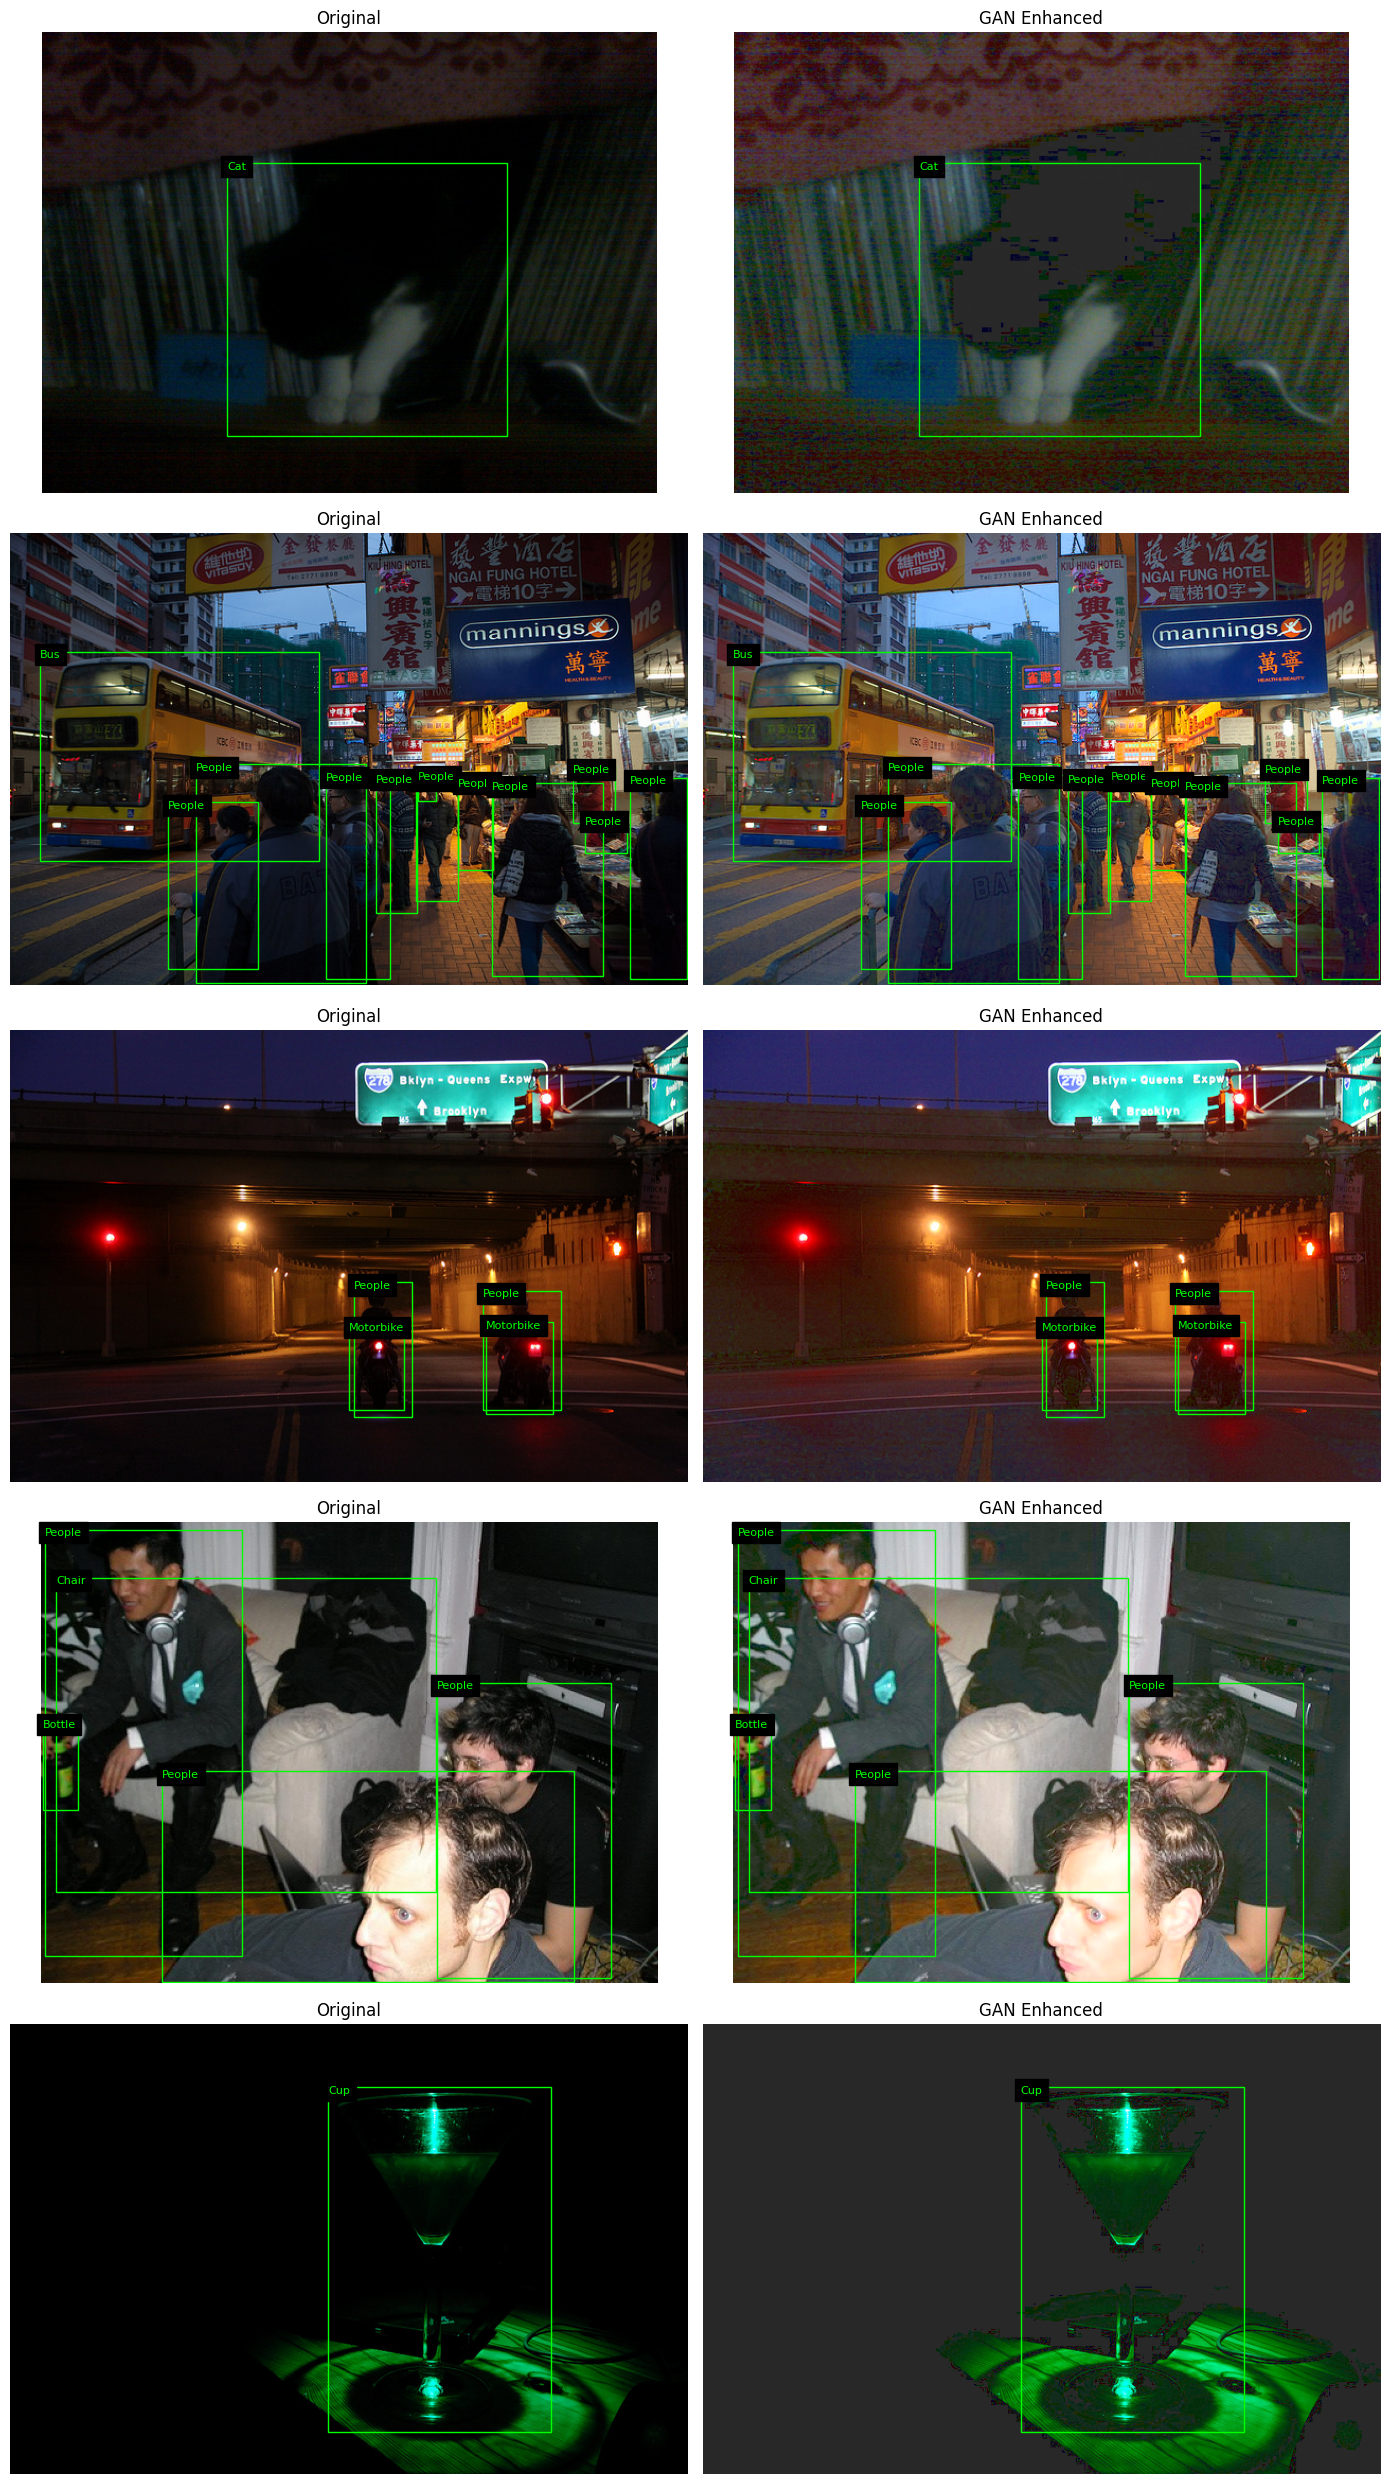

In [10]:
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

# Paths
dataset_path = "/kaggle/input/object-detection-exdark/ExDark"
annot_path = "/kaggle/input/object-detection-exdark/ExDark_Annno"

# Get all image paths
image_paths = []
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(root, file))

# Select random images
random.seed(42)
selected_images = random.sample(image_paths, 5)

def gan_enhance(image):
    # Placeholder for GAN enhancement.
    # Replace this with actual GAN inference code.
    # For demonstration, we'll just increase brightness.
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsv[...,2] = cv2.add(hsv[...,2], 40)
    enhanced = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return enhanced

# Visualization: 2 columns (original, GAN-enhanced)
fig, axes = plt.subplots(nrows=len(selected_images), ncols=2, figsize=(14, 5*len(selected_images)))
if len(selected_images) == 1: axes = [axes]  # Handle single image case

for idx, img_path in enumerate(selected_images):
    # Read image
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    enhanced_image = gan_enhance(image)

    # Build annotation path
    rel_path = os.path.relpath(img_path, dataset_path)
    annot_file_path = os.path.join(annot_path, rel_path + ".txt")
    
    # Check annotation existence
    if not os.path.exists(annot_file_path):
        print(f"Annotation {annot_file_path} not found - skipping")
        continue
    
    # Parse annotations
    boxes = []
    labels = []
    with open(annot_file_path, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('%') or not line: continue
            parts = line.split()
            class_name = parts[0]
            x, y, w, h = map(int, parts[1:5])
            boxes.append((x, y, w, h))
            labels.append(class_name)

    # Draw original image with annotations
    ax_orig = axes[idx][0] if len(selected_images) > 1 else axes[0]
    ax_orig.imshow(image)
    for (x, y, w, h), label in zip(boxes, labels):
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='lime', facecolor='none')
        ax_orig.add_patch(rect)
        ax_orig.text(x, y-2, label, color='lime', fontsize=8, va='top', backgroundcolor='black')
    ax_orig.set_title("Original")
    ax_orig.axis('off')

    # Draw GAN-enhanced image with same annotations
    ax_enh = axes[idx][1] if len(selected_images) > 1 else axes[1]
    ax_enh.imshow(enhanced_image)
    for (x, y, w, h), label in zip(boxes, labels):
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='lime', facecolor='none')
        ax_enh.add_patch(rect)
        ax_enh.text(x, y-2, label, color='lime', fontsize=8, va='top', backgroundcolor='black')
    ax_enh.set_title("GAN Enhanced")
    ax_enh.axis('off')

plt.tight_layout()
plt.show()

In [8]:
import os
import cv2
import torch
import torchvision
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from torchmetrics.detection import MeanAveragePrecision
from tqdm import tqdm
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection import FasterRCNN
from torch.cuda import amp  # Mixed precision

In [12]:
# Configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_EPOCHS = 10
BATCH_SIZE = 8
LEARNING_RATE = 0.005
IMG_SIZE = 224
CLASSES = ['Bicycle', 'Boat', 'Bottle', 'Bus', 'Car', 'Cat', 
          'Chair', 'Cup', 'Dog', 'Motorbike', 'People', 'Table']
NUM_CLASSES = len(CLASSES) + 1
DATASET_PATH = "/kaggle/input/object-detection-exdark/ExDark"
ANNOT_PATH = "/kaggle/input/object-detection-exdark/ExDark_Annno"

In [13]:
# --- GAN Enhancement Function ---
def gan_enhance(image):
    # Placeholder for GAN enhancement.
    # Replace with actual GAN inference if available.
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsv[...,2] = cv2.add(hsv[...,2], 40)
    enhanced = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return enhanced

# Custom Dataset (MODIFIED)
class ExDarkDataset(Dataset):
    def __init__(self, root_dir, annot_dir, classes, transform=None, use_gan=False):
        self.root_dir = root_dir
        self.annot_dir = annot_dir
        self.transform = transform
        self.use_gan = use_gan
        self.class_to_idx = {cls: i+1 for i, cls in enumerate(classes)}
        self.image_paths = []
        self.annotations = {}  # Cache annotations
        
        # Collect valid image paths and pre-load annotations
        for root, _, files in os.walk(root_dir):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(root, file)
                    annot_path = self._get_annot_path(img_path)
                    if os.path.exists(annot_path):
                        with open(annot_path, 'r') as f:
                            lines = [line.strip() for line in f 
                                     if line.strip() and not line.startswith('%')]
                        if lines:
                            self.image_paths.append(img_path)
                            self.annotations[img_path] = lines

    def _get_annot_path(self, img_path):
        rel_path = os.path.relpath(img_path, self.root_dir)
        return os.path.join(self.annot_dir, rel_path + ".txt")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h, w = image.shape[:2]
        
        # --- Apply GAN enhancement if enabled ---
        if self.use_gan:
            image = gan_enhance(image)
        
        # Resize image upfront (MODIFIED)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        scale_x, scale_y = IMG_SIZE/w, IMG_SIZE/h
        
        boxes = []
        labels = []
        
        for line in self.annotations[img_path]:
            parts = line.split()
            class_name = parts[0]
            x, y, w_box, h_box = map(int, parts[1:5])
            
            # Scale bounding boxes (MODIFIED)
            xmin = max(0, min(w-1, x)) * scale_x
            ymin = max(0, min(h-1, y)) * scale_y
            xmax = max(0, min(w, x + w_box)) * scale_x
            ymax = max(0, min(h, y + h_box)) * scale_y
            
            # Skip invalid boxes
            if (xmax - xmin) < 1 or (ymax - ymin) < 1:
                continue
                
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(self.class_to_idx[class_name])
        
        if len(boxes) == 0:
            return self[(idx + 1) % len(self)]
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        # Normalize image (MODIFIED)
        image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
        image = torchvision.transforms.functional.normalize(
            image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        
        return image, {'boxes': boxes, 'labels': labels}

In [14]:
# Model Architecture
def create_model():
    backbone = torchvision.models.mobilenet_v3_large(pretrained=True).features
    backbone.out_channels = 960
    
    # Adjusted anchor sizes for 224x224 input
    anchor_generator = AnchorGenerator(
        sizes=((16, 32, 64, 128, 256),),  # Smaller anchors
        aspect_ratios=((0.5, 1.0, 2.0),)
    )
    
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(
        featmap_names=['0'],
        output_size=7,
        sampling_ratio=2
    )
    
    return FasterRCNN(
        backbone,
        num_classes=NUM_CLASSES,
        rpn_anchor_generator=anchor_generator,
        box_roi_pool=roi_pooler
    )

In [15]:
# Data Loading
def collate_fn(batch):
    return tuple(zip(*batch))

def create_datasets():
    # Create datasets with enhancement enabled
    full_dataset = ExDarkDataset(DATASET_PATH, ANNOT_PATH, CLASSES, apply_enhancement=True)
    train_size = int(0.7 * len(full_dataset))
    val_size = int(0.15 * len(full_dataset))
    test_size = len(full_dataset) - train_size - val_size
    return torch.utils.data.random_split(full_dataset, [train_size, val_size, test_size])

train_dataset, val_dataset, test_dataset = create_datasets()

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, 
    shuffle=True, collate_fn=collate_fn, num_workers=4, pin_memory=True
)

val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, 
    shuffle=False, collate_fn=collate_fn, num_workers=4, pin_memory=True
)

test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, 
    shuffle=False, collate_fn=collate_fn, num_workers=4, pin_memory=True
)

In [16]:
# Training Setup
model = create_model().to(DEVICE)
optimizer = torch.optim.SGD(
    [p for p in model.parameters() if p.requires_grad],
    lr=LEARNING_RATE, momentum=0.9, weight_decay=0.0005
)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
scaler = amp.GradScaler()  # Mixed precision

/tmp/ipykernel_126/2779070467.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()  # Mixed precision


In [17]:
# Training and Evaluation
train_loss_history = []
val_loss_history = []
val_map_history = []
test_map_history = []
val_acc_history = []
test_acc_history = []
all_val_preds = []
all_val_targets = []
all_test_preds = []
all_test_targets = []

for epoch in range(NUM_EPOCHS):
    # Training with mixed precision
    model.train()
    epoch_train_loss = 0
    train_bar = tqdm(train_loader, desc=f"Train Epoch {epoch+1}")
    for images, targets in train_bar:
        images = [img.to(DEVICE, non_blocking=True) for img in images]
        targets = [{k: v.to(DEVICE, non_blocking=True) for k, v in t.items()} for t in targets]
        
        with torch.amp.autocast('cuda'):
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
        
        optimizer.zero_grad()
        scaler.scale(losses).backward()
        scaler.step(optimizer)
        scaler.update()
        
        epoch_train_loss += losses.item()
        train_bar.set_postfix(loss=losses.item())
    
    train_loss = epoch_train_loss/len(train_loader)
    train_loss_history.append(train_loss)
    lr_scheduler.step()

    # Validation
    model.eval()
    metric = MeanAveragePrecision()
    preds_for_cm = []
    targets_for_cm = []
    correct = 0
    total = 0
    epoch_val_loss = 0
    val_batches = 0

    with torch.no_grad():
        for images, targets in tqdm(val_loader, desc=f"Val Epoch {epoch+1}"):
            images = [img.to(DEVICE, non_blocking=True) for img in images]
            targets_gpu = [{k: v.to(DEVICE, non_blocking=True) for k, v in t.items()} for t in targets]
            
            # Compute validation loss
            model.train()
            with torch.amp.autocast('cuda'):
                loss_dict = model(images, targets_gpu)
                losses = sum(loss for loss in loss_dict.values())
                epoch_val_loss += losses.item()
                val_batches += 1
            model.eval()
            
            # Get predictions
            with torch.amp.autocast('cuda'):
                predictions = model(images)
            
            metric.update(predictions, targets_gpu)
            
            # Accuracy calculation
            for i, (pred, target) in enumerate(zip(predictions, targets)):
                mask = pred['scores'] > 0.5
                pred_labels = pred['labels'][mask].cpu().numpy()
                true_labels = target['labels'].cpu().numpy()
                
                min_len = min(len(pred_labels), len(true_labels))
                if min_len > 0:
                    matches = np.sum(pred_labels[:min_len] == true_labels[:min_len])
                    correct += matches
                    total += min_len
                
                if epoch == NUM_EPOCHS-1 and len(pred_labels) == len(true_labels) and len(pred_labels) > 0:
                    preds_for_cm.extend(pred_labels)
                    targets_for_cm.extend(true_labels)
    
    val_loss = epoch_val_loss / val_batches if val_batches > 0 else 0
    val_loss_history.append(val_loss)

    map_metrics = metric.compute()
    val_map = map_metrics['map'].item()
    val_map_history.append(val_map)
    val_acc = correct / total if total > 0 else 0
    val_acc_history.append(val_acc)
    
    if epoch == NUM_EPOCHS-1:
        all_val_preds = preds_for_cm
        all_val_targets = targets_for_cm

    # Testing
    metric_test = MeanAveragePrecision()
    preds_for_cm_test = []
    targets_for_cm_test = []
    correct_test = 0
    total_test = 0
    
    with torch.no_grad():
        for images, targets in tqdm(test_loader, desc=f"Test Epoch {epoch+1}"):
            images = [img.to(DEVICE, non_blocking=True) for img in images]
            targets_gpu = [{k: v.to(DEVICE, non_blocking=True) for k, v in t.items()} for t in targets]
            
            with torch.amp.autocast('cuda'):
                predictions = model(images)
            
            metric_test.update(predictions, targets_gpu)
            
            for i, (pred, target) in enumerate(zip(predictions, targets)):
                mask = pred['scores'] > 0.5
                pred_labels = pred['labels'][mask].cpu().numpy()
                true_labels = target['labels'].cpu().numpy()
                
                min_len = min(len(pred_labels), len(true_labels))
                if min_len > 0:
                    matches = np.sum(pred_labels[:min_len] == true_labels[:min_len])
                    correct_test += matches
                    total_test += min_len
                
                if epoch == NUM_EPOCHS-1 and len(pred_labels) == len(true_labels) and len(pred_labels) > 0:
                    preds_for_cm_test.extend(pred_labels)
                    targets_for_cm_test.extend(true_labels)
    
    map_metrics_test = metric_test.compute()
    test_map = map_metrics_test['map'].item()
    test_map_history.append(test_map)
    test_acc = correct_test / total_test if total_test > 0 else 0
    test_acc_history.append(test_acc)
    
    if epoch == NUM_EPOCHS-1:
        all_test_preds = preds_for_cm_test
        all_test_targets = targets_for_cm_test

    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val mAP: {val_map:.4f} | Test mAP: {test_map:.4f}")
    print(f"Validation Acc: {val_acc:.4f} | Test Acc: {test_acc:.4f}\n")


Train Epoch 1:  29%|██▉       | 187/644 [01:25<03:22,  2.26it/s, loss=0.436]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
Train Epoch 1:  40%|███▉      | 257/644 [01:57<02:52,  2.24it/s, loss=0.75] libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
Test Epoch 1: 100%|██████████| 139/139 [00:42<00:00,  3.27it/s]



Epoch 1/10
Train Loss: 0.6258 | Val Loss: 0.5513 | Val mAP: 0.0280 | Test mAP: 0.0273
Validation Acc: 0.7083 | Test Acc: 0.5610



Train Epoch 2:   0%|          | 0/644 [00:00<?, ?it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
Train Epoch 2:  51%|█████▏    | 331/644 [02:34<02:19,  2.25it/s, loss=0.405]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
Test Epoch 2: 100%|██████████| 139/139 [00:42<00:00,  3.31it/s]



Epoch 2/10
Train Loss: 0.5236 | Val Loss: 0.5218 | Val mAP: 0.0758 | Test mAP: 0.0684
Validation Acc: 0.5863 | Test Acc: 0.5435



Train Epoch 3:  86%|████████▌ | 551/644 [04:11<00:42,  2.19it/s, loss=0.355]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
Train Epoch 3:  98%|█████████▊| 634/644 [04:48<00:04,  2.23it/s, loss=0.464]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
Test Epoch 3: 100%|██████████| 139/139 [00:42<00:00,  3.25it/s]



Epoch 3/10
Train Loss: 0.4844 | Val Loss: 0.5008 | Val mAP: 0.1113 | Test mAP: 0.1077
Validation Acc: 0.6436 | Test Acc: 0.5753



Train Epoch 4:  39%|███▉      | 250/644 [01:55<02:58,  2.20it/s, loss=0.452]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
Train Epoch 4:  63%|██████▎   | 408/644 [03:07<01:51,  2.11it/s, loss=0.525]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
Test Epoch 4: 100%|██████████| 139/139 [00:42<00:00,  3.28it/s]



Epoch 4/10
Train Loss: 0.4483 | Val Loss: 0.4726 | Val mAP: 0.1329 | Test mAP: 0.1273
Validation Acc: 0.6501 | Test Acc: 0.5844



Train Epoch 5:  35%|███▌      | 227/644 [01:45<03:11,  2.18it/s, loss=0.428]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
Train Epoch 5:  80%|███████▉  | 513/644 [03:55<00:58,  2.23it/s, loss=0.346]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
Test Epoch 5: 100%|██████████| 139/139 [00:42<00:00,  3.29it/s]



Epoch 5/10
Train Loss: 0.4459 | Val Loss: 0.4682 | Val mAP: 0.1396 | Test mAP: 0.1319
Validation Acc: 0.6347 | Test Acc: 0.5897



Train Epoch 6:  27%|██▋       | 171/644 [01:18<03:32,  2.22it/s, loss=0.259]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
Train Epoch 6:  31%|███       | 201/644 [01:32<03:20,  2.21it/s, loss=0.484]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
Test Epoch 6: 100%|██████████| 139/139 [00:42<00:00,  3.28it/s]



Epoch 6/10
Train Loss: 0.4439 | Val Loss: 0.4795 | Val mAP: 0.1460 | Test mAP: 0.1373
Validation Acc: 0.6444 | Test Acc: 0.5831



Train Epoch 7:  17%|█▋        | 109/644 [00:50<04:00,  2.22it/s, loss=0.608]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
Train Epoch 7:  84%|████████▎ | 539/644 [04:07<00:48,  2.19it/s, loss=0.726]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
Test Epoch 7: 100%|██████████| 139/139 [00:42<00:00,  3.24it/s]



Epoch 7/10
Train Loss: 0.4409 | Val Loss: 0.4725 | Val mAP: 0.1459 | Test mAP: 0.1373
Validation Acc: 0.6436 | Test Acc: 0.5845



Train Epoch 8:  77%|███████▋  | 495/644 [03:47<01:08,  2.18it/s, loss=0.572]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
Train Epoch 8:  91%|█████████▏| 588/644 [04:29<00:25,  2.24it/s, loss=0.716]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
Test Epoch 8: 100%|██████████| 139/139 [00:42<00:00,  3.27it/s]



Epoch 8/10
Train Loss: 0.4402 | Val Loss: 0.4744 | Val mAP: 0.1452 | Test mAP: 0.1370
Validation Acc: 0.6395 | Test Acc: 0.5865



Train Epoch 9:  12%|█▏        | 80/644 [00:38<04:11,  2.24it/s, loss=0.314]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
Train Epoch 9:  34%|███▍      | 222/644 [01:42<03:10,  2.22it/s, loss=0.45] libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
Test Epoch 9: 100%|██████████| 139/139 [00:42<00:00,  3.30it/s]



Epoch 9/10
Train Loss: 0.4400 | Val Loss: 0.4702 | Val mAP: 0.1454 | Test mAP: 0.1379
Validation Acc: 0.6444 | Test Acc: 0.5829



Train Epoch 10:  58%|█████▊    | 373/644 [02:51<02:04,  2.18it/s, loss=0.441]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
Train Epoch 10:  61%|██████    | 390/644 [02:59<01:54,  2.21it/s, loss=0.44] libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
Test Epoch 10: 100%|██████████| 139/139 [00:42<00:00,  3.26it/s]



Epoch 10/10
Train Loss: 0.4384 | Val Loss: 0.4703 | Val mAP: 0.1454 | Test mAP: 0.1378
Validation Acc: 0.6404 | Test Acc: 0.5843



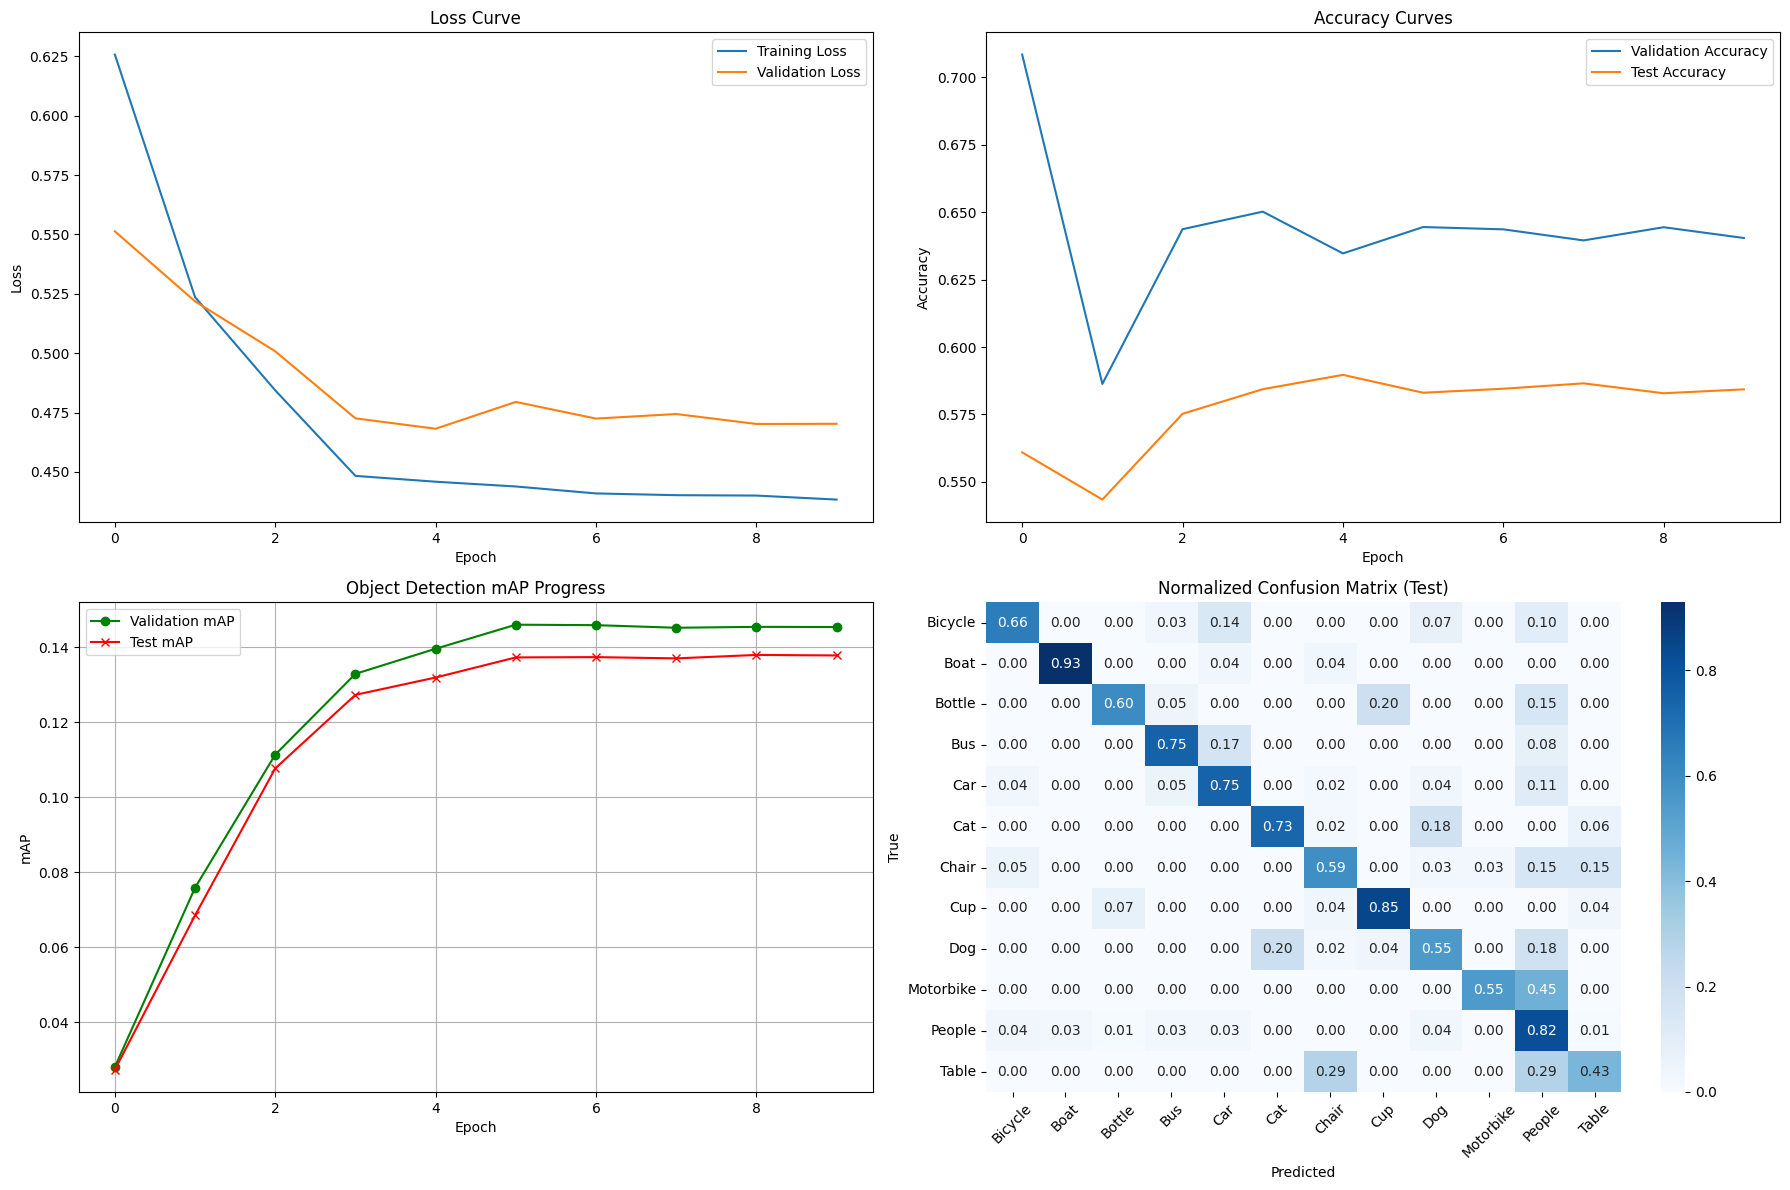

In [18]:
# Visualization
plt.figure(figsize=(18, 12))

# Loss Curve (train and validation)
plt.subplot(2, 2, 1)
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy Curves
plt.subplot(2, 2, 2)
plt.plot(val_acc_history, label='Validation Accuracy')
plt.plot(test_acc_history, label='Test Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# mAP Curve
plt.subplot(2, 2, 3)
plt.plot(val_map_history, color='green', marker='o', label='Validation mAP')
plt.plot(test_map_history, color='red', marker='x', label='Test mAP')
plt.title('Object Detection mAP Progress')
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.legend()
plt.grid(True)

# Confusion Matrix (Test)
plt.subplot(2, 2, 4)
cm = confusion_matrix(all_test_targets, all_test_preds, labels=range(1, NUM_CLASSES))
row_sums = cm.sum(axis=1, keepdims=True)
cm = np.divide(cm.astype('float'), row_sums, where=row_sums != 0)
cm = np.nan_to_num(cm)

sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Normalized Confusion Matrix (Test)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()
plt.close()

In [19]:
# Classification Report (Test)
report = classification_report(
    all_test_targets, all_test_preds,
    target_names=CLASSES,
    labels=range(1, NUM_CLASSES),
    digits=4
)
print("\nClassification Report (Test):")
print(report)


Classification Report (Test):
              precision    recall  f1-score   support

     Bicycle     0.7037    0.6552    0.6786        29
        Boat     0.8966    0.9286    0.9123        28
      Bottle     0.8000    0.6000    0.6857        20
         Bus     0.6923    0.7500    0.7200        24
         Car     0.7736    0.7455    0.7593        55
         Cat     0.7826    0.7347    0.7579        49
       Chair     0.6765    0.5897    0.6301        39
         Cup     0.7931    0.8519    0.8214        27
         Dog     0.6000    0.5510    0.5745        49
   Motorbike     0.9231    0.5455    0.6857        22
      People     0.6591    0.8208    0.7311       106
       Table     0.4500    0.4286    0.4390        21

    accuracy                         0.7100       469
   macro avg     0.7292    0.6834    0.6996       469
weighted avg     0.7161    0.7100    0.7075       469



In [20]:
# Detailed Metrics (Test)
metrics_str = "\nDetailed Test Metrics:\n"
for key, value in map_metrics_test.items():
    if isinstance(value, torch.Tensor):
        if value.numel() == 1:
            metrics_str += f"{key:20}: {value.item():.4f}\n"
        else:
            metrics_str += f"{key:20}: {[round(v.item(), 4) for v in value]}\n"
print(metrics_str)



Detailed Test Metrics:
map                 : 0.1378
map_50              : 0.3356
map_75              : 0.0753
map_small           : 0.0206
map_medium          : 0.1495
map_large           : 0.2870
mar_1               : 0.1830
mar_10              : 0.2953
mar_100             : 0.3109
mar_small           : 0.0958
mar_medium          : 0.3529
mar_large           : 0.4841
map_per_class       : -1.0000
mar_100_per_class   : -1.0000
classes             : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]



In [ ]:
# Save Model
torch.save(model.state_dict(), 'exdark_detection_model_enhanced.pth')
print("Training complete! Model saved.")